## Get a simple data set object together

In [1]:
import tensorflow as tf
from keras.layers import Conv2D, LeakyReLU, Input, Dense, MaxPooling2D, Activation, Conv2DTranspose, Concatenate,Dropout
from keras.models import Model, Sequential
import keras
import matplotlib.pyplot as plt

In [2]:
#Make the dataset
from cycleganstyletransfer.config import DATA_DIR
data_dir = DATA_DIR / "raw"


my_monet_ds_train, my_monet_ds_val = tf.keras.utils.image_dataset_from_directory(
    data_dir / "Monet",
    validation_split=0.2,
    subset="both",
    seed=42,
    image_size=(128, 128),
    batch_size = 1,
    labels = None,
)

my_image_ds_train, my_image_ds_val = tf.keras.utils.image_dataset_from_directory(
    data_dir / "Images",
    validation_split=0.2,
    subset="both",
    seed=42,
    image_size=(128, 128),
    batch_size = 1,
    labels = None,
)

my_monet_ds_train = my_monet_ds_train.map(lambda x: (x / 127.5) - 1)
my_image_ds_train = my_image_ds_train.map(lambda x: (x / 127.5) - 1)


DATASET_HEIGHT = max(len(my_monet_ds_train), len(my_image_ds_train))

my_monet_ds_train = iter(my_monet_ds_train.shuffle(42).repeat())
my_image_ds_train = iter(my_image_ds_train.shuffle(42).repeat())

2025-06-13 05:00:31.669 | INFO     | cycleganstyletransfer.config:<module>:11 - PROJ_ROOT path is: C:\Users\willi\Desktop\AIPortfolio\CycleGanV2\cycleganstyletransfer


Found 1193 files belonging to 1 classes.
Using 955 files for training.
Using 238 files for validation.
Found 7037 files belonging to 1 classes.
Using 5630 files for training.
Using 1407 files for validation.


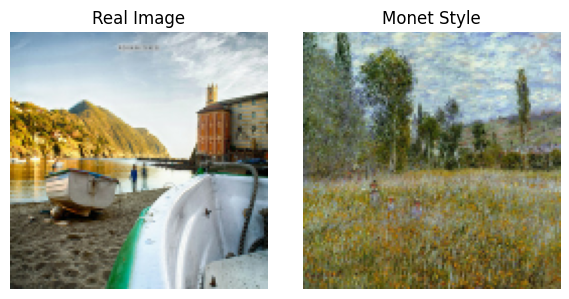

In [25]:
# Fetch one image from each dataset iterator
example_monet = next(my_monet_ds_train)
example_image = next(my_image_ds_train)

# Rescale back from [-1, 1] to [0, 1] for visualization
example_monet = (example_monet[0] + 1) / 2.0
example_image = (example_image[0] + 1) / 2.0

# Plot the two images side by side
plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 2)
plt.imshow(example_monet)
plt.title("Monet Style")
plt.axis("off")

plt.subplot(1, 2, 1)
plt.imshow(example_image)
plt.title("Real Image")
plt.axis("off")

plt.tight_layout()
plt.show()

## Put the Discrim model together

In [3]:
def build_discriminator(input_shape=(128, 128, 3)):
    inputs = Input(shape=input_shape)
    
    # First layer doesn't use instance normalization
    x = Conv2D(16, 3,padding='same')(inputs)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.3)(x)
    x = MaxPooling2D(2)(x)

    x = Conv2D(32, 3,padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.3)(x)
    x = MaxPooling2D(2)(x)

    x = Conv2D(64, 3,padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.3)(x)
    x = MaxPooling2D(2)(x)

    x = Conv2D(1, 3, padding='same')(x)
    
    return Model(inputs, x, name='discriminator')

my_discriminator = build_discriminator()
my_discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 16)      0         
                                                                 
 dropout (Dropout)           (None, 128, 128, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                     

## Generator model

In [4]:
class InstanceNormalization(keras.layers.Layer):
    def __init__(self, epsilon=1e-5, **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        # One scale and bias per channel
        self.gamma = self.add_weight(
            shape=(input_shape[-1],),
            initializer='ones',
            trainable=True,
            name='gamma'
        )
        self.beta = self.add_weight(
            shape=(input_shape[-1],),
            initializer='zeros',
            trainable=True,
            name='beta'
        )
        super(InstanceNormalization, self).build(input_shape)

    def call(self, inputs):
        # Compute mean and variance per instance, per channel
        mean, variance = tf.nn.moments(inputs, axes=[1, 2], keepdims=True)
        normalized = (inputs - mean) / tf.sqrt(variance + self.epsilon)
        return self.gamma * normalized + self.beta

    def get_config(self):
        config = super().get_config().copy()
        config.update({"epsilon": self.epsilon})
        return config


In [5]:
def DownSampleBlock(filters:int, kernel_size:int, strides:int):
    ret_block = Sequential()
    ret_block.add(Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same'))
    ret_block.add(InstanceNormalization())
    ret_block.add(Activation('relu'))
    return ret_block


In [6]:
from keras.layers import UpSampling2D, Conv2D
import uuid

def UpSampleBlock(filters: int, kernel_size: int, strides: int):
    ret_block = Sequential(name=f'UpsampleBlock_{uuid.uuid4()}')
    ret_block.add(UpSampling2D(size=(strides, strides), interpolation='bilinear'))  # replaces strided transpose
    ret_block.add(Conv2D(filters=filters, kernel_size=kernel_size, padding='same'))
    ret_block.add(InstanceNormalization())
    ret_block.add(Activation('relu'))
    return ret_block


In [7]:

def Generator(input_shape: tuple, kernel_size: int = 3,
              filter_line: list[int] = [32, 64, 128]) -> Model:
    skip_connections = []
    input_block = Input(shape=input_shape)
    ret_block = input_block

    # Encoder — save outputs *before* downsampling
    for filters in filter_line:
        skip_connections.append(ret_block)
        ret_block = DownSampleBlock(filters, 3, 2)(ret_block)

    # Decoder — reverse order and match spatial shapes
    for filters, skip in zip(filter_line[::-1], skip_connections[::-1]):
        ret_block = UpSampleBlock(filters, 3, 2)(ret_block)
        ret_block = Concatenate()([ret_block, skip])

    # Final output layer (no additional upsampling)
    ret_block = Conv2D(input_shape[-1], kernel_size=kernel_size, padding='same', activation='tanh')(ret_block)

    return Model(inputs=input_block, outputs=ret_block)

In [8]:
my_generator = Generator((128, 128, 3))
my_generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 64, 64, 32)           960       ['input_2[0][0]']             
                                                                                                  
 sequential_1 (Sequential)   (None, 32, 32, 64)           18624     ['sequential[0][0]']          
                                                                                                  
 sequential_2 (Sequential)   (None, 16, 16, 128)          74112     ['sequential_1[0][0]']        
                                                                                              

In [9]:
def my_square_loss(y_true, y_pred):
    y_true = tf.reshape(tf.cast(y_true, tf.float32), (-1, 1, 1, 1))
    y_true = tf.broadcast_to(y_true, tf.shape(y_pred))
    return tf.reduce_mean(tf.math.squared_difference(y_true, y_pred))


## Training loop without generator training (Monet Domain)

In [10]:
from keras.optimizers import Adam
import numpy as np
import time

NUM_EPOCHS = 2
EPOCH_LENGTH = DATASET_HEIGHT // 20
DISPLAY_INTERVAL = 5  # record loss every 5 steps

my_optimiser = Adam(learning_rate=0.0002, beta_1=0.5)

my_generator = Generator((128, 128, 3))
my_discriminator = build_discriminator()

all_losses = []

for i in range(NUM_EPOCHS):
    print(f"\nEpoch {i + 1}/{NUM_EPOCHS}")
    epoch_losses = []
    start_time = time.time()

    for j in range(EPOCH_LENGTH):
        monet_image = (next(my_monet_ds_train)) 
        real_image = (next(my_image_ds_train))

        with tf.GradientTape() as tape:
            real_monet = monet_image
            fake_monet = my_generator(real_image)


            real_monet_output = my_discriminator(real_monet)
            fake_monet_output = my_discriminator(fake_monet)

            loss = 0.5 * (
                my_square_loss(tf.constant(1.0), real_monet_output) +
                my_square_loss(tf.constant(0.0), fake_monet_output)
            )

        grads = tape.gradient(loss, my_discriminator.trainable_variables)
        my_optimiser.apply_gradients(zip(grads, my_discriminator.trainable_variables))

        if j % DISPLAY_INTERVAL == 0:
            epoch_losses.append(tf.squeeze(loss).numpy())
        print(f"\rStep {j + 1}/{EPOCH_LENGTH} - loss: {epoch_losses[-1]:.4f}", end='')

    epoch_avg_loss = np.mean(epoch_losses)
    print(f"\nEpoch {i + 1} completed in {int(time.time() - start_time)}s - avg loss: {epoch_avg_loss:.4f}")
    all_losses.extend(epoch_losses)


Epoch 1/2
Step 281/281 - loss: 0.1789
Epoch 1 completed in 171s - avg loss: 0.0974

Epoch 2/2
Step 281/281 - loss: 0.0270
Epoch 2 completed in 199s - avg loss: 0.0475


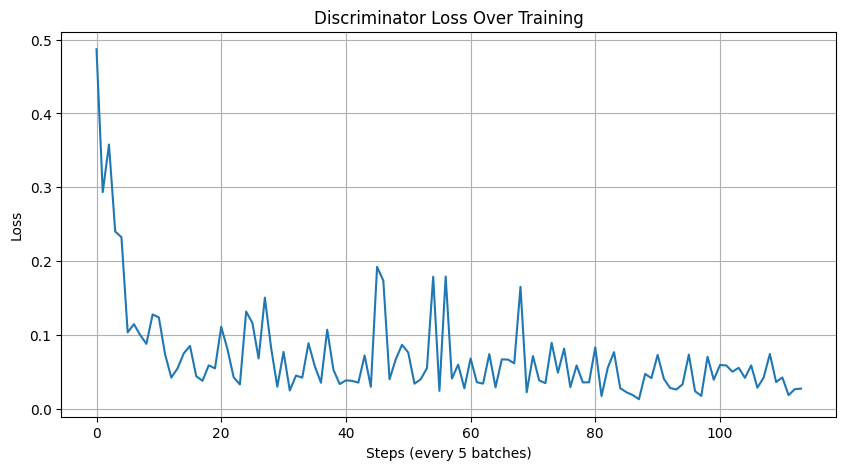

In [13]:
# Plot full training loss curve
plt.figure(figsize=(10, 5))
plt.plot(all_losses)
plt.title('Discriminator Loss Over Training')
plt.xlabel(f'Steps (every {DISPLAY_INTERVAL} batches)')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

## Introducing Generator loss

In [14]:
from keras.losses import binary_crossentropy

In [15]:
def generator_loss(descrim_output):
        return tf.reduce_mean(tf.math.squared_difference(tf.ones_like(descrim_output), descrim_output))

In [27]:
def to_display(img):
    return (img[0] + 1) / 2 #* 0.5 + 0.5#tf.clip_by_value(img * 0.5 + 0.5, 0.0, 1.0)



Epoch 1/2


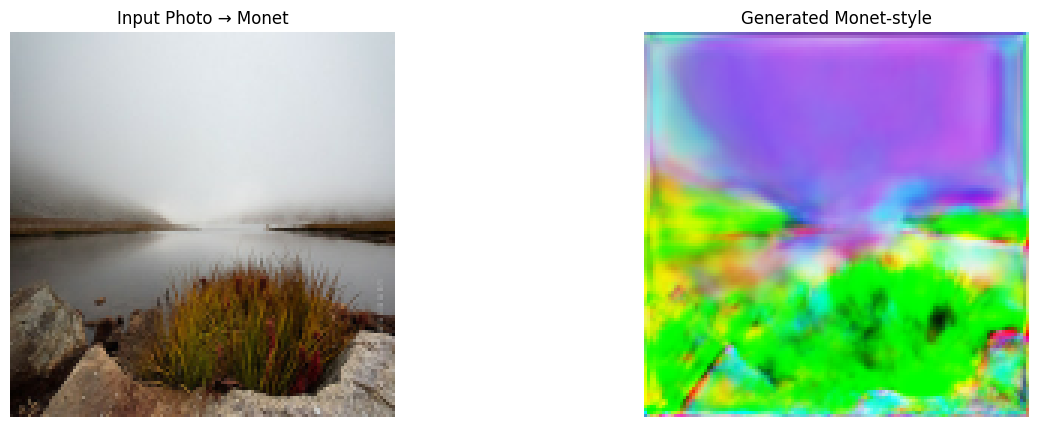

Step 100/281 - discriminator loss: 0.3170, generator loss: 0.3774

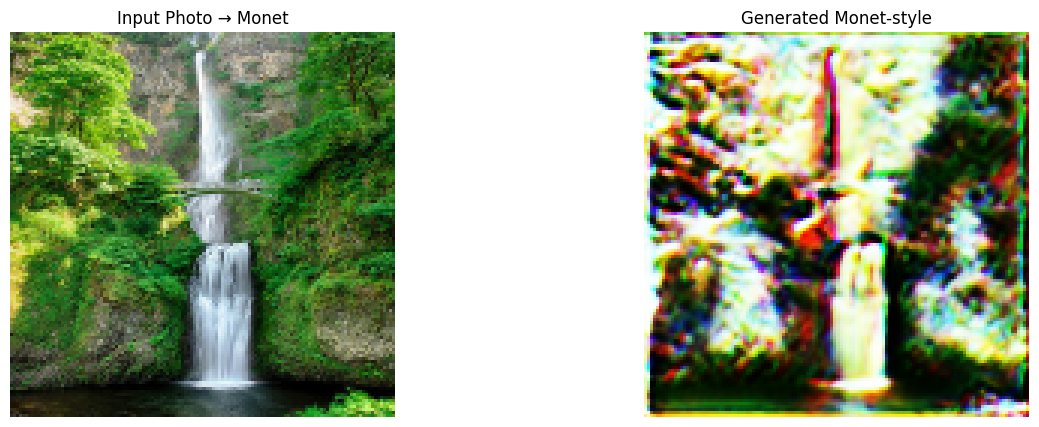

Step 200/281 - discriminator loss: 0.2109, generator loss: 0.2173

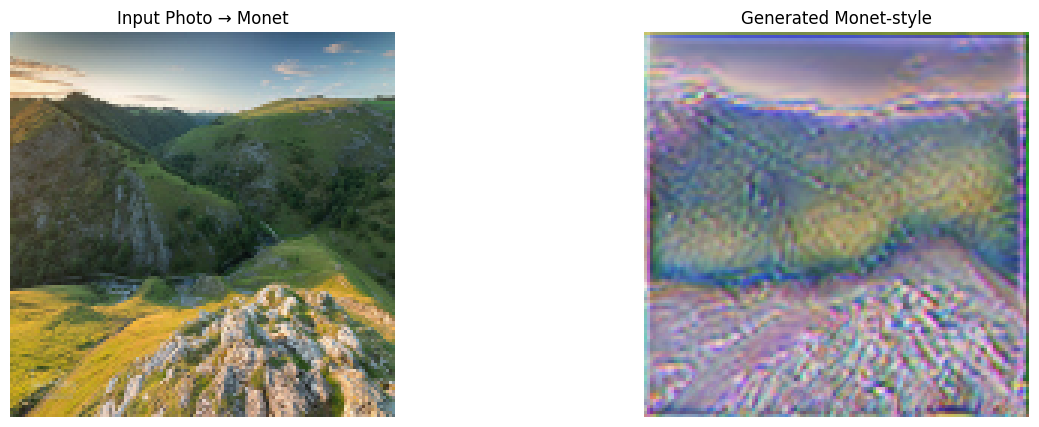

Step 281/281 - discriminator loss: 0.2398, generator loss: 0.2439
Epoch 1 completed in 234s - avg discriminator loss: 0.2853, avg generator loss: 0.3464

Epoch 2/2


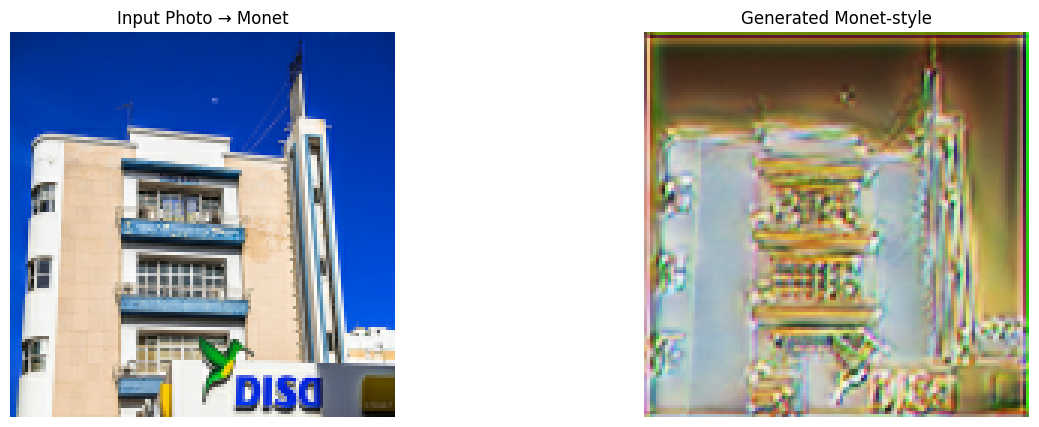

Step 100/281 - discriminator loss: 0.2975, generator loss: 0.2499

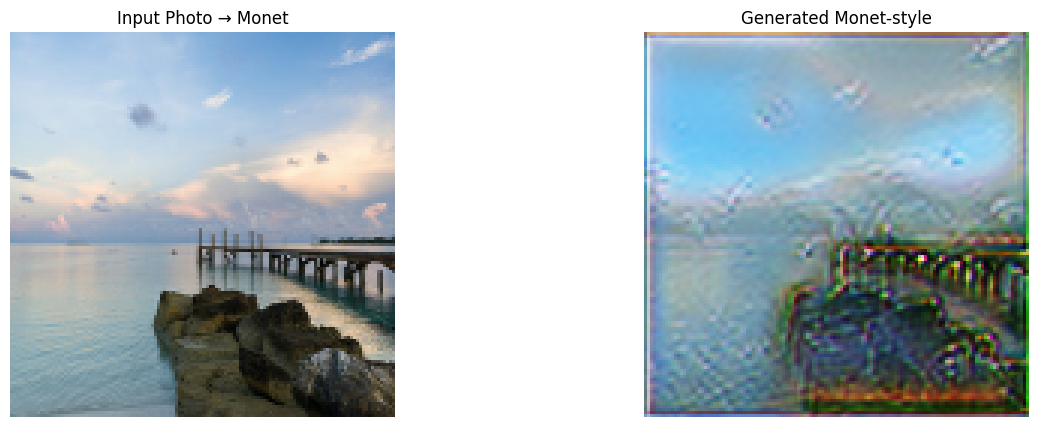

Step 200/281 - discriminator loss: 0.2370, generator loss: 0.2869

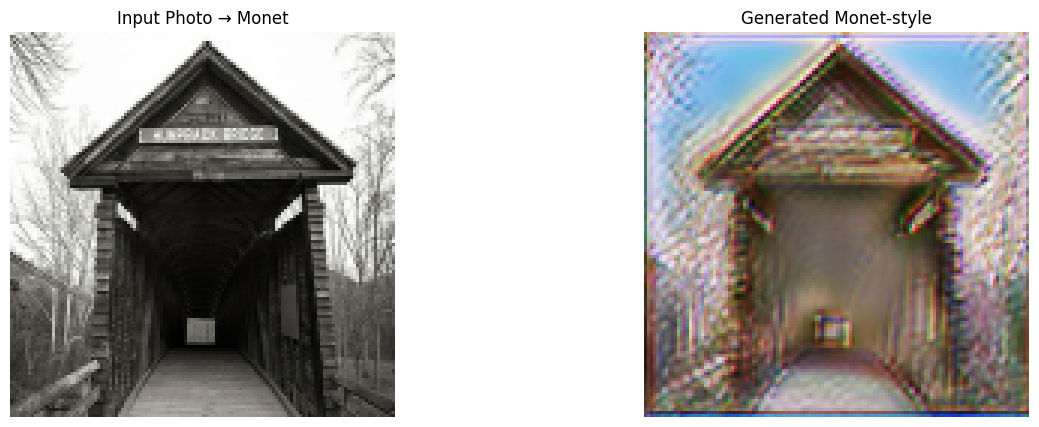

Step 281/281 - discriminator loss: 0.2561, generator loss: 0.2441
Epoch 2 completed in 196s - avg discriminator loss: 0.2630, avg generator loss: 0.2613


In [30]:
from keras.optimizers import Adam
import numpy as np
import time

NUM_EPOCHS = 2
EPOCH_LENGTH = DATASET_HEIGHT // 20
DISPLAY_INTERVAL = 5  # record loss every 5 steps

my_optimiser = Adam(learning_rate=0.0002, beta_1=0.5)
gen_optimiser = Adam(learning_rate=0.0002, beta_1=0.5)

my_generator = Generator((128, 128, 3))
my_discriminator = build_discriminator()

eg_image = next(my_image_ds_train)
eg_output = my_generator(eg_image)

all_losses = []

for i in range(NUM_EPOCHS):
    print(f"\nEpoch {i + 1}/{NUM_EPOCHS}")
    epoch_losses = []
    start_time = time.time()

    for j in range(EPOCH_LENGTH):
        monet_image = (next(my_monet_ds_train)) 
        real_image = (next(my_image_ds_train))


        if j % 100 == 0:
            test_photo_to_monet = my_generator(real_image)
            #test_monet_to_photo = photo_generator(monet_image)
            
            plt.figure(figsize=(15, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(to_display(real_image))
            plt.title('Input Photo → Monet')
            plt.axis('off')
            
            plt.subplot(1, 2, 2)
            plt.imshow(to_display(test_photo_to_monet))
            plt.title('Generated Monet-style')
            plt.axis('off')
            plt.show()
            plt.close()

        with tf.GradientTape(persistent=True) as tape:
            real_monet = monet_image
            fake_monet = my_generator(real_image)

            real_monet_output = my_discriminator(real_monet)
            fake_monet_output = my_discriminator(fake_monet)

            loss = 0.5 * (
                my_square_loss(tf.constant(1.0), real_monet_output) +
                my_square_loss(tf.constant(0.0), fake_monet_output)
            )

            monet_generator_loss = generator_loss(fake_monet_output)

        grads = tape.gradient(loss, my_discriminator.trainable_variables)
        my_optimiser.apply_gradients(zip(grads, my_discriminator.trainable_variables))

        generator_grads =  tape.gradient(monet_generator_loss, my_generator.trainable_variables)
        gen_optimiser.apply_gradients(zip(generator_grads, my_generator.trainable_variables))

        if j % DISPLAY_INTERVAL == 0:
            disc_loss = tf.squeeze(loss).numpy()
            gen_loss = tf.squeeze(monet_generator_loss).numpy()
            epoch_losses.append((disc_loss, gen_loss))
        print(f"\rStep {j + 1}/{EPOCH_LENGTH} - discriminator loss: {epoch_losses[-1][0]:.4f}, generator loss: {epoch_losses[-1][1]:.4f}", end='')

    epoch_avg_disc_loss = np.mean([l[0] for l in epoch_losses])
    epoch_avg_gen_loss = np.mean([l[1] for l in epoch_losses])
    print(f"\nEpoch {i + 1} completed in {int(time.time() - start_time)}s - avg discriminator loss: {epoch_avg_disc_loss:.4f}, avg generator loss: {epoch_avg_gen_loss:.4f}")
    all_losses.extend(epoch_losses)


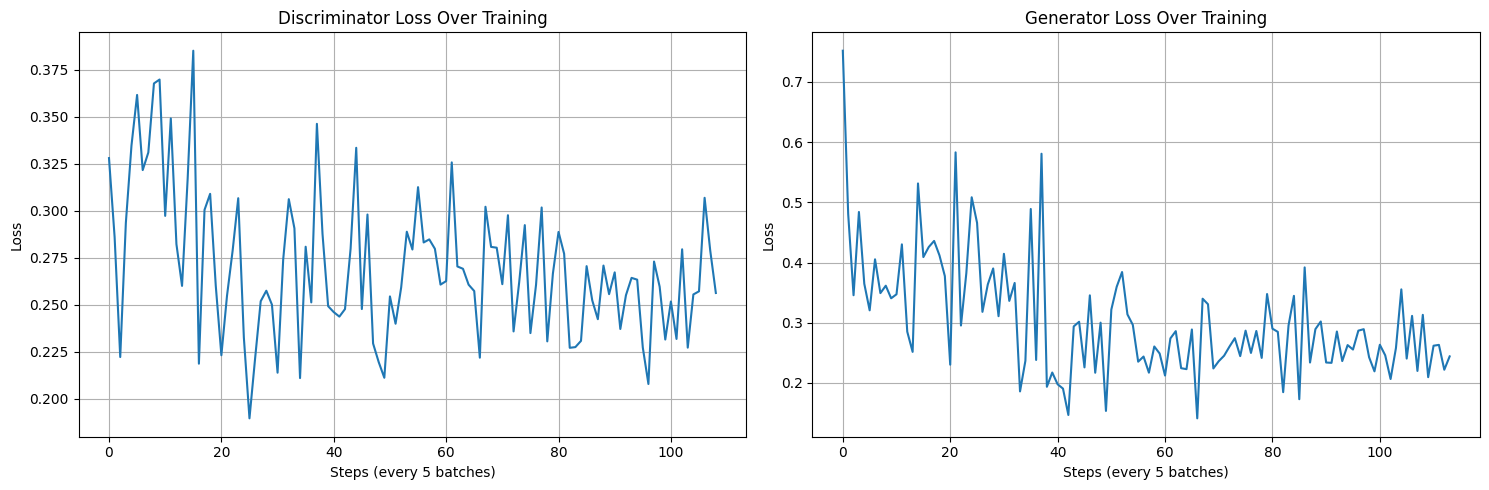

In [31]:

# Plot full training loss curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
disc_losses = [l[0] for l in all_losses]
plt.plot(disc_losses[5:])
plt.title('Discriminator Loss Over Training')
plt.xlabel(f'Steps (every {DISPLAY_INTERVAL} batches)')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
gen_losses = [l[1] for l in all_losses]
plt.plot(gen_losses)
plt.title('Generator Loss Over Training')
plt.xlabel(f'Steps (every {DISPLAY_INTERVAL} batches)')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

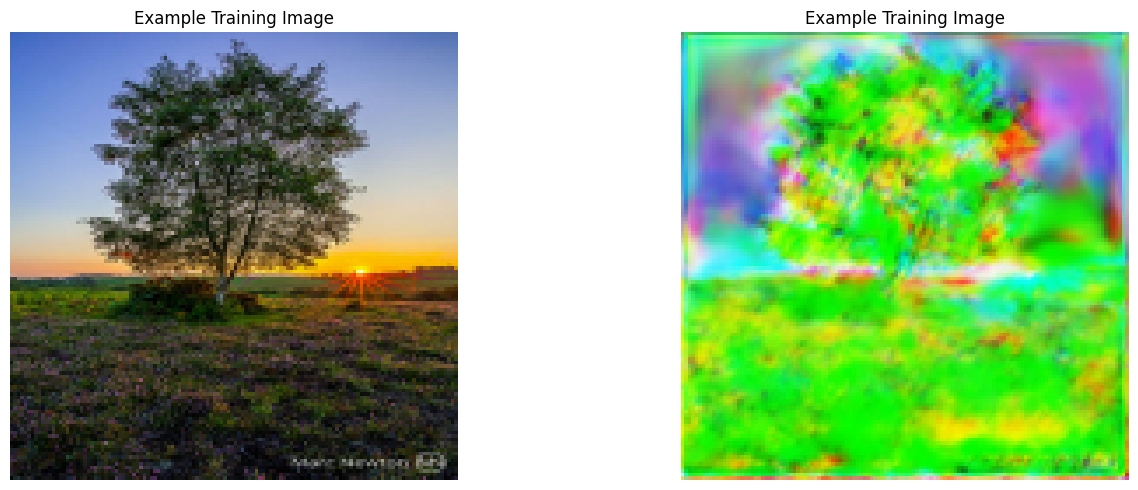

In [32]:
# Plot full training loss curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.imshow(eg_image[0] * 0.5 + 0.5)  # Normalize the image from [0,255] to [0,1] for display
plt.axis('off')
plt.title('Example Training Image')


plt.subplot(1, 2, 2)
plt.imshow(eg_output[0] * 0.5 + 0.5)  # Denormalize the image for display
plt.axis('off')
plt.title('Example Training Image')


plt.tight_layout()
plt.show()


In [33]:
eg_output2 = my_generator(eg_image)

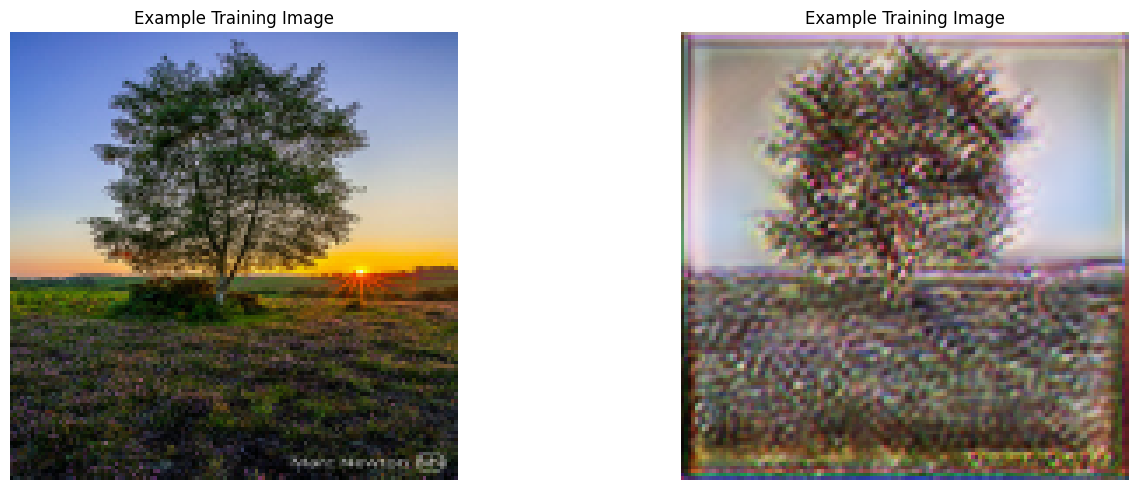

In [34]:
# Plot full training loss curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.imshow(eg_image[0] * 0.5 + 0.5)  # Normalize the image from [0,255] to [0,1] for display
plt.axis('off')
plt.title('Example Training Image')


plt.subplot(1, 2, 2)
plt.imshow(eg_output2[0] * 0.5 + 0.5)  # Denormalize the image for display
plt.axis('off')
plt.title('Example Training Image')


plt.tight_layout()
plt.show()


## Fix Padding issues

In [35]:
from keras.layers import Lambda

In [36]:
# Reflection padding to replace zero padding
def ReflectionPad2D(pad: int):
    return Lambda(lambda x: tf.pad(x, [[0,0], [pad,pad], [pad,pad], [0,0]], mode='REFLECT'))


In [37]:

def DownSampleBlock(filters: int, kernel_size: int, strides: int):
    pad = kernel_size // 2
    block = Sequential()
    block.add(ReflectionPad2D(pad))  # prevents edge distortion
    block.add(Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='valid'))
    block.add(InstanceNormalization())
    block.add(Activation('relu'))
    return block


In [38]:

def UpSampleBlock(filters: int, kernel_size: int, strides: int):
    pad = kernel_size // 2
    block = Sequential(name=f'UpsampleBlock_{uuid.uuid4()}')
    block.add(UpSampling2D(size=(strides, strides), interpolation='bilinear'))
    block.add(ReflectionPad2D(pad))  # again avoid zero padding artifacts
    block.add(Conv2D(filters=filters, kernel_size=kernel_size, padding='valid'))
    block.add(InstanceNormalization())
    block.add(Activation('relu'))
    return block

In [40]:

def Generator(input_shape: tuple, kernel_size: int = 3,
              filter_line: list[int] = [32, 64, 128]) -> Model:
    input_block = Input(shape=input_shape)
    x = input_block
    skips = []

    # Encoder
    for filters in filter_line:
        x = DownSampleBlock(filters, kernel_size, strides=2)(x)
        skips.append(x)

    # Decoder
    for filters, skip in zip(filter_line[::-1][1:], skips[::-1][1:]):
        x = UpSampleBlock(filters, kernel_size, strides=2)(x)
        # Ensure spatial match due to valid padding
        crop_h = (skip.shape[1] - x.shape[1]) // 2
        crop_w = (skip.shape[2] - x.shape[2]) // 2
        if crop_h > 0 or crop_w > 0:
            skip = Lambda(lambda t: t[:, crop_h:crop_h+x.shape[1], crop_w:crop_w+x.shape[2], :])(skip)
        x = Concatenate()([x, skip])

    # Final upsample
    x = UpSampleBlock(filter_line[0], kernel_size, strides=2)(x)

    # Final output layer
    pad = kernel_size // 2
    x = ReflectionPad2D(pad)(x)
    x = Conv2D(input_shape[-1], kernel_size=kernel_size, padding='valid', activation='tanh')(x)

    return Model(inputs=input_block, outputs=x)

test = Generator((128, 128, 3))
test.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_24 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 sequential_36 (Sequential)  (None, 64, 64, 32)           960       ['input_24[0][0]']            
                                                                                                  
 sequential_37 (Sequential)  (None, 32, 32, 64)           18624     ['sequential_36[0][0]']       
                                                                                                  
 sequential_38 (Sequential)  (None, 16, 16, 128)          74112     ['sequential_37[0][0]']       
                                                                                           

(1, 128, 128, 3)

Epoch 1/2


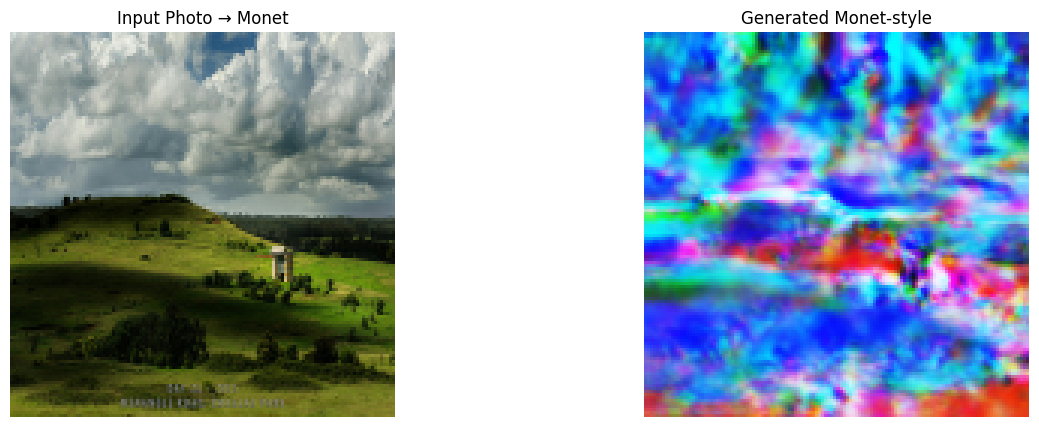

Step 100/1126 - discriminator loss: 0.3181, generator loss: 0.3458

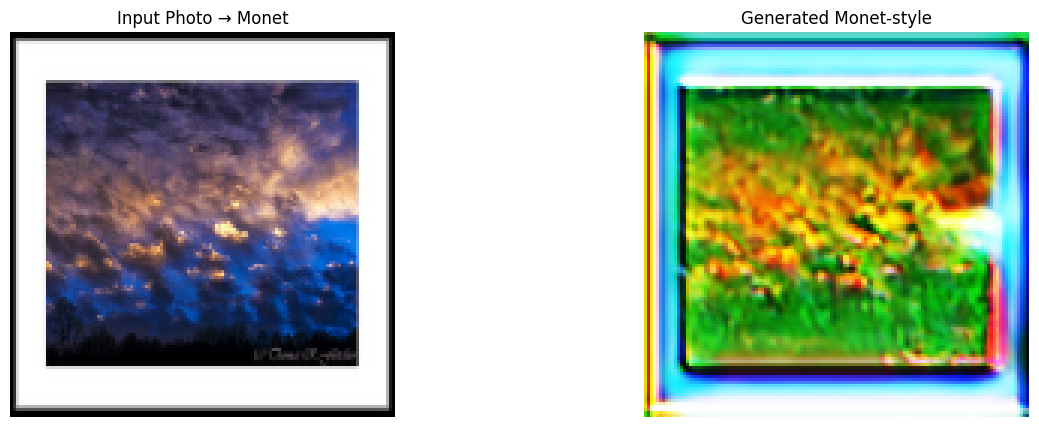

Step 200/1126 - discriminator loss: 0.2773, generator loss: 0.2320

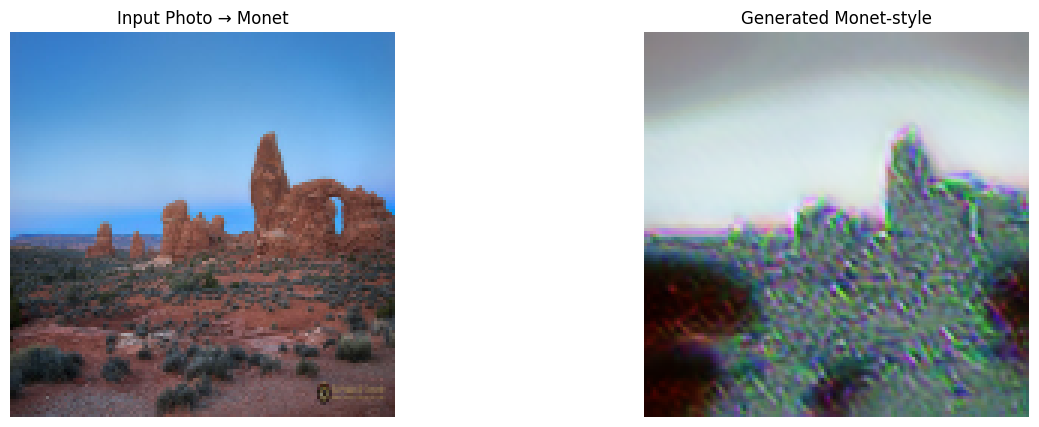

Step 300/1126 - discriminator loss: 0.2384, generator loss: 0.1917

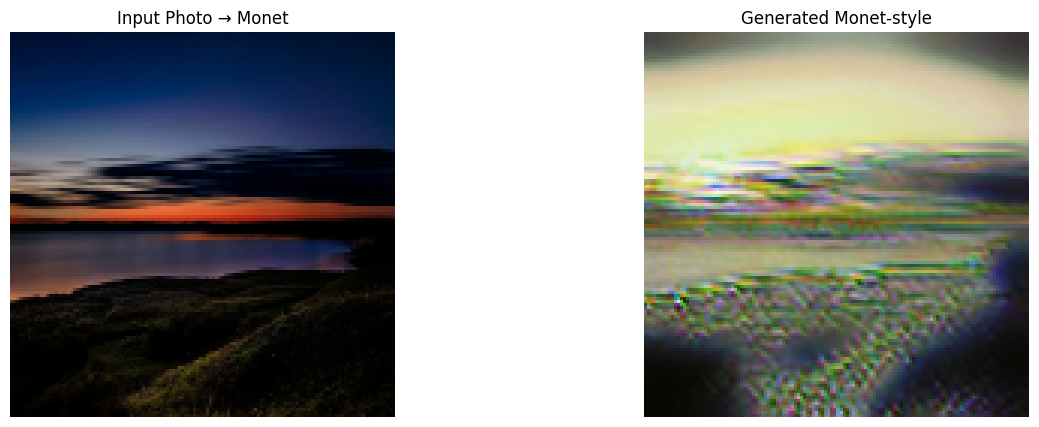

Step 400/1126 - discriminator loss: 0.2722, generator loss: 0.2849

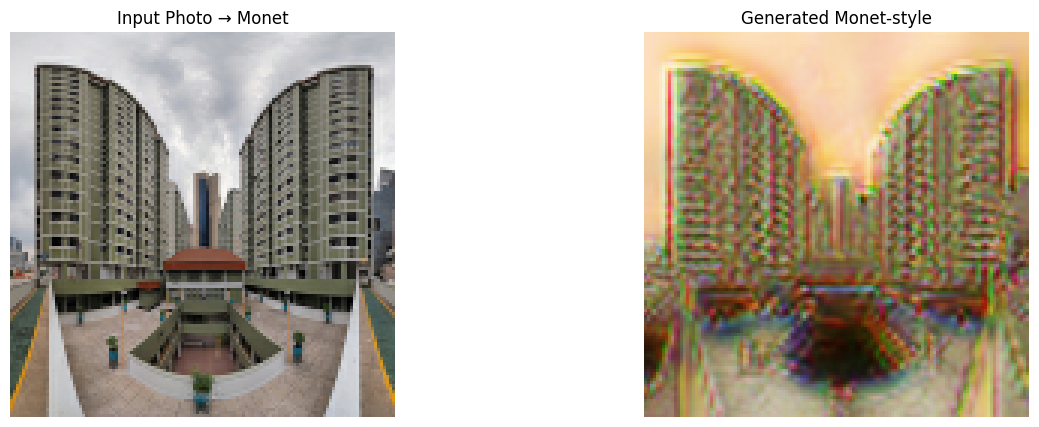

Step 500/1126 - discriminator loss: 0.2213, generator loss: 0.2416

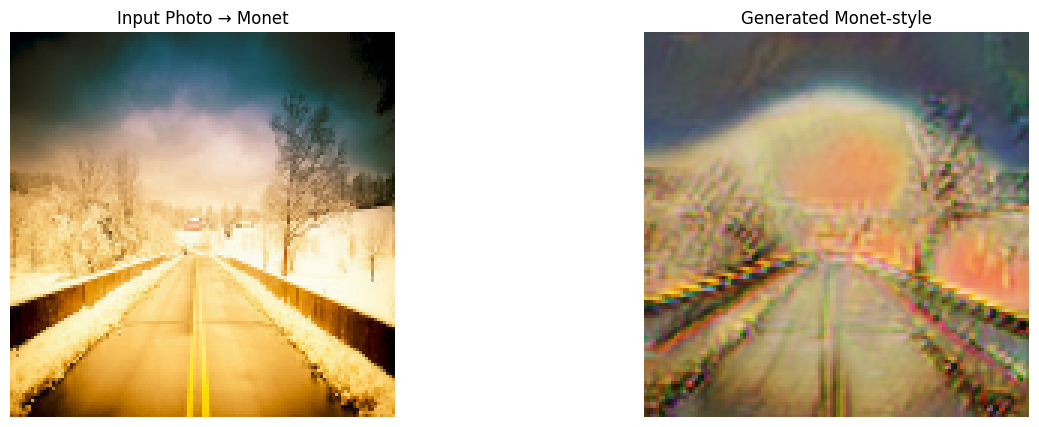

Step 600/1126 - discriminator loss: 0.2649, generator loss: 0.2543

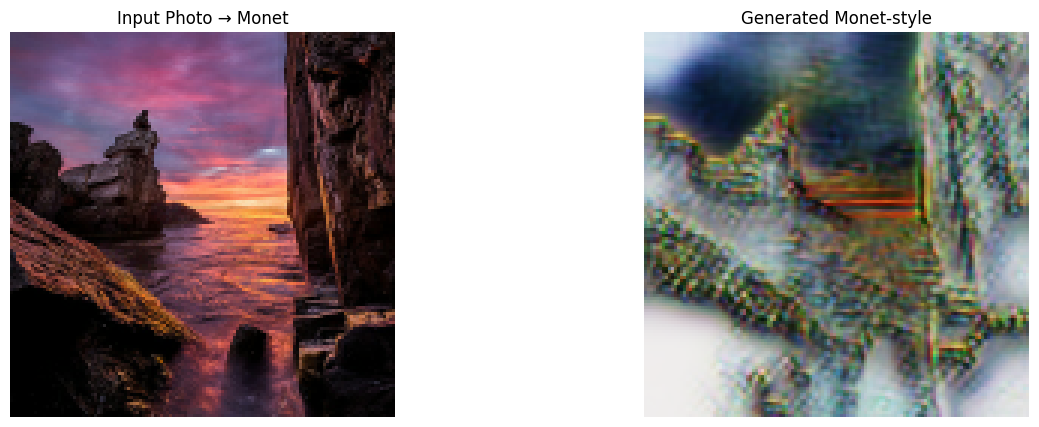

Step 700/1126 - discriminator loss: 0.2734, generator loss: 0.2654

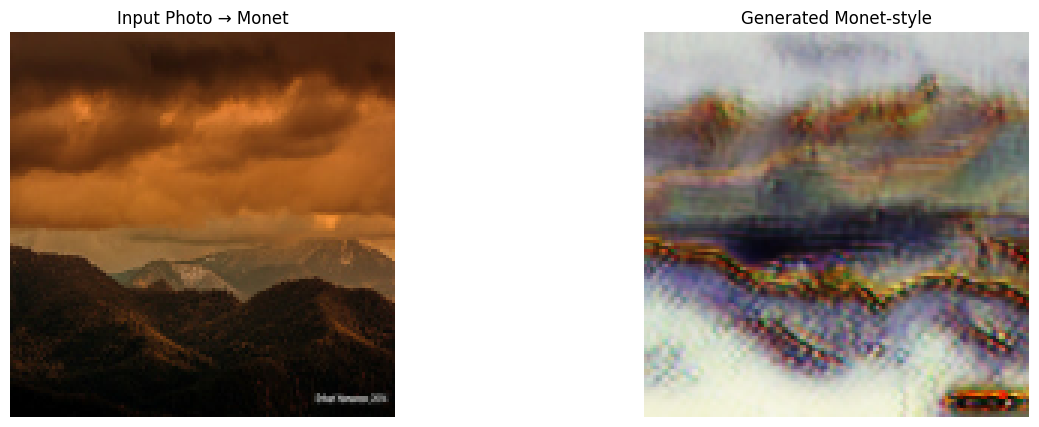

Step 800/1126 - discriminator loss: 0.2403, generator loss: 0.2200

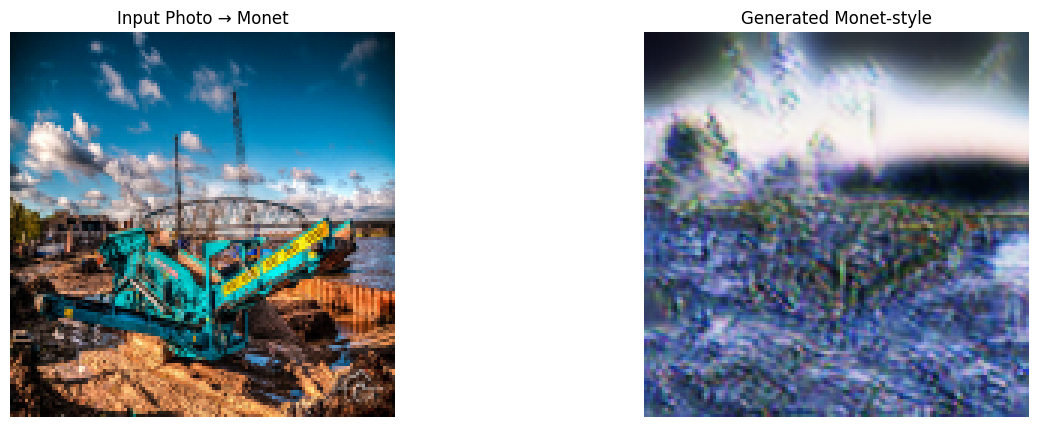

Step 900/1126 - discriminator loss: 0.2597, generator loss: 0.2587

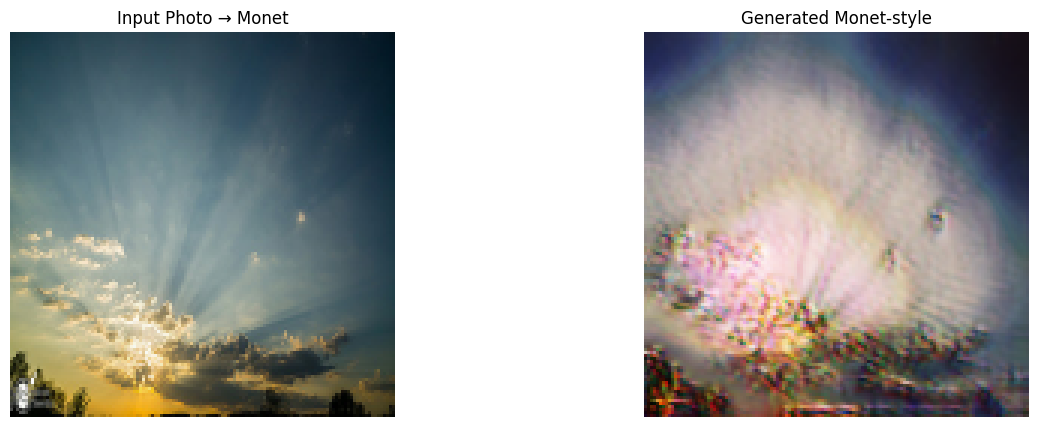

Step 1000/1126 - discriminator loss: 0.2567, generator loss: 0.2598

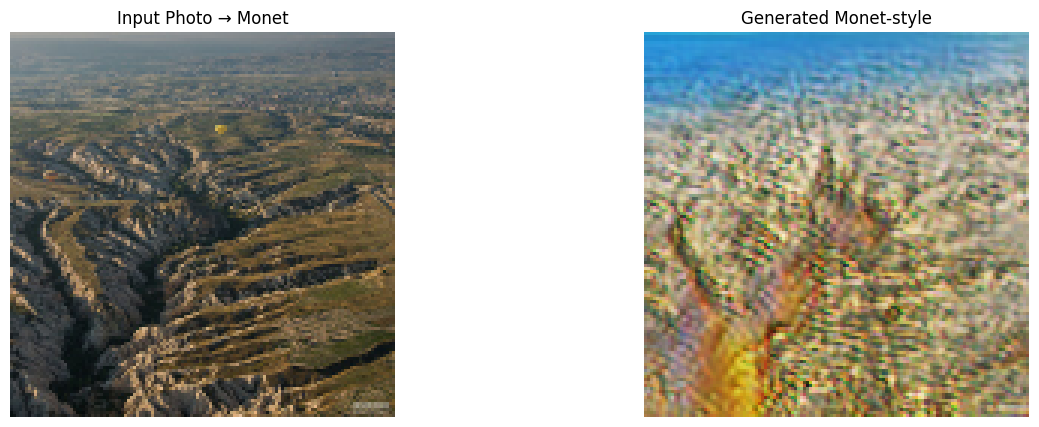

Step 1100/1126 - discriminator loss: 0.2512, generator loss: 0.3497

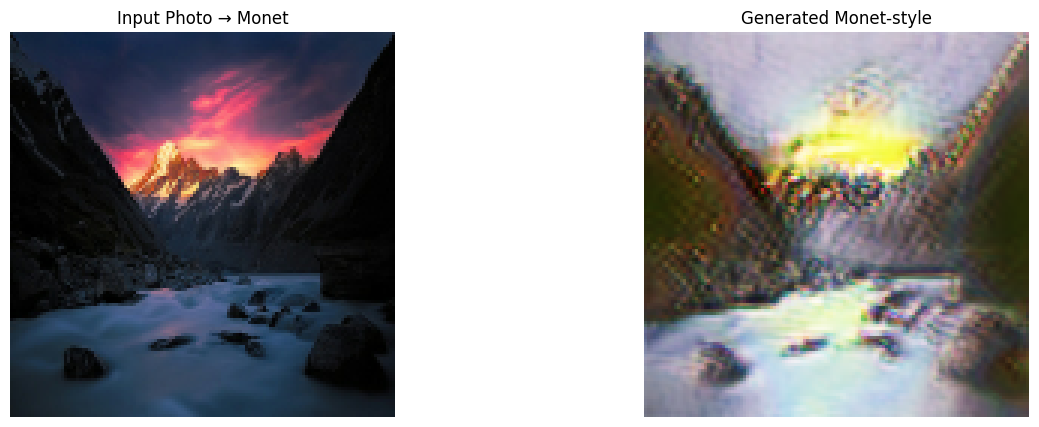

Step 1126/1126 - discriminator loss: 0.2575, generator loss: 0.2209
Epoch 1 completed in 693s - avg discriminator loss: 0.2644, avg generator loss: 0.2884

Epoch 2/2


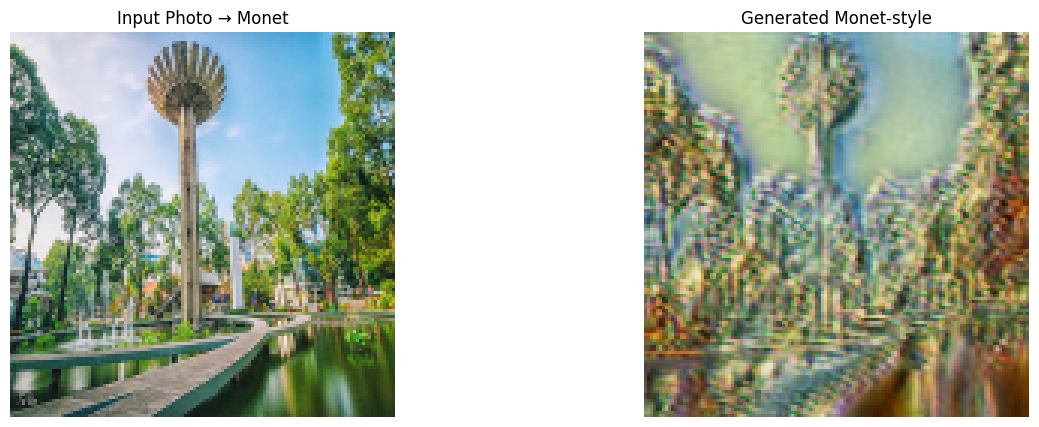

Step 100/1126 - discriminator loss: 0.2619, generator loss: 0.2211

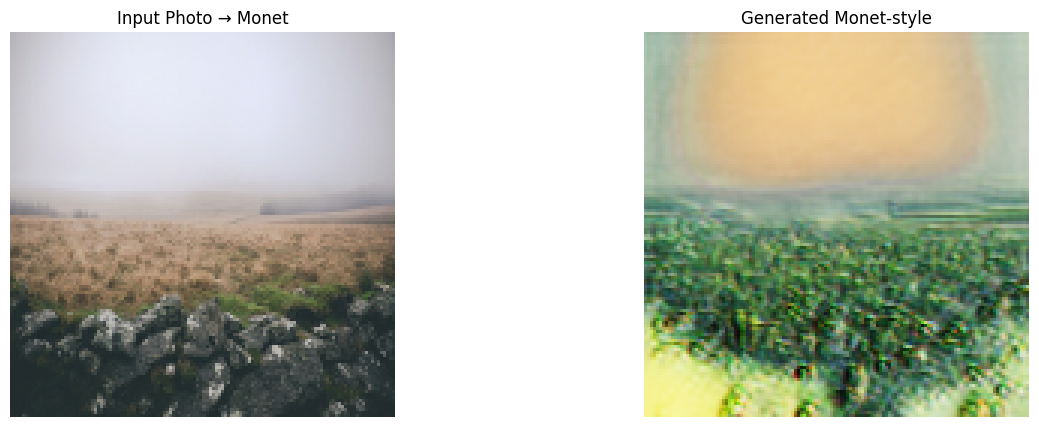

Step 200/1126 - discriminator loss: 0.2219, generator loss: 0.3173

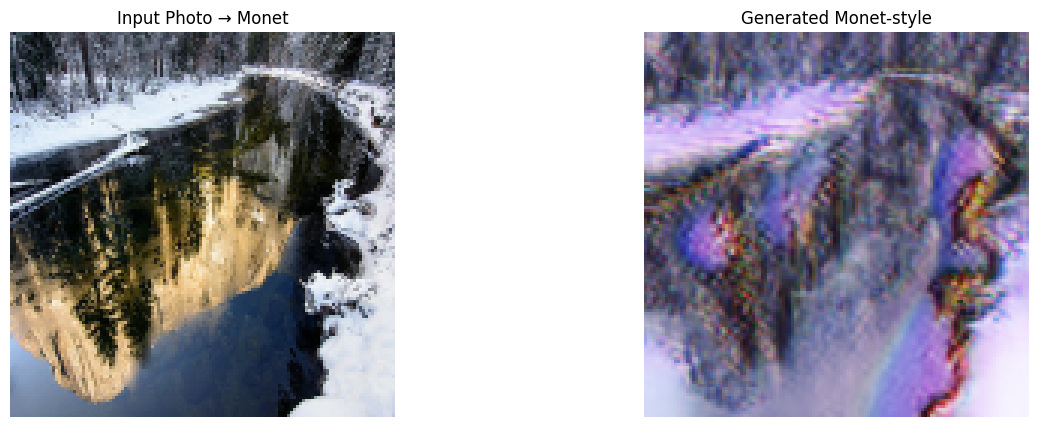

Step 300/1126 - discriminator loss: 0.2434, generator loss: 0.2247

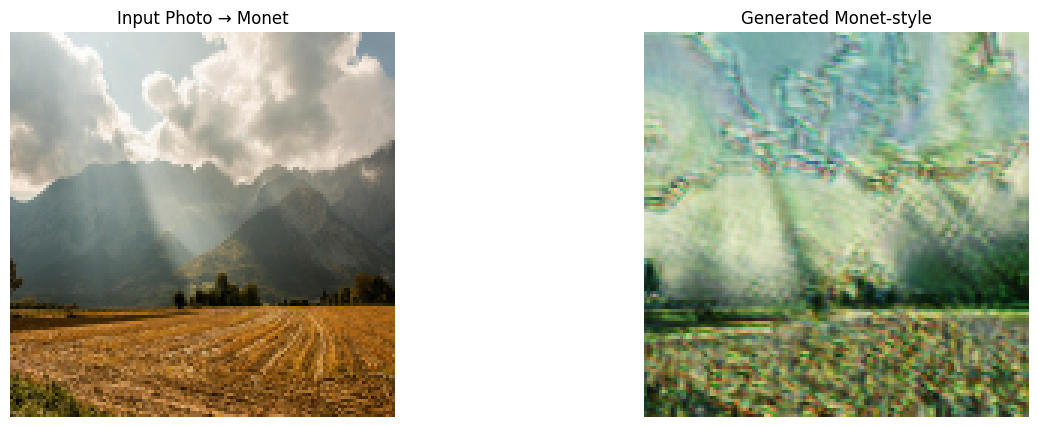

Step 400/1126 - discriminator loss: 0.2652, generator loss: 0.2550

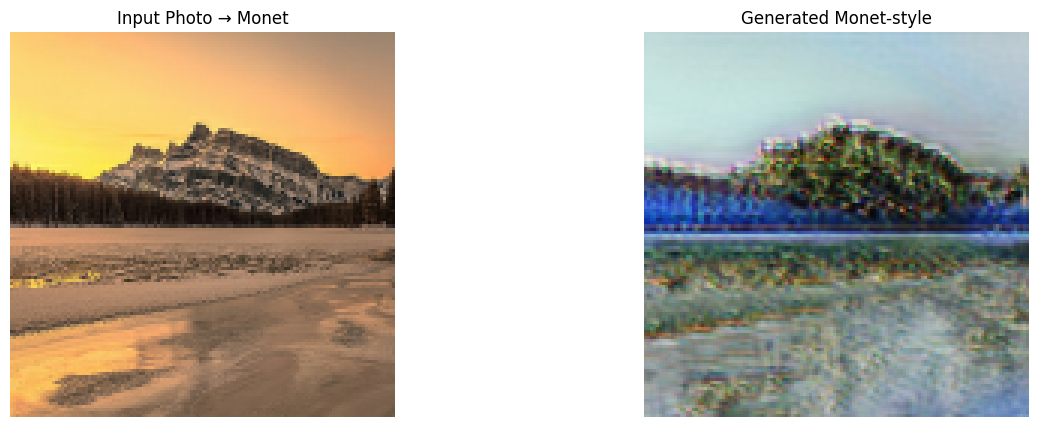

Step 500/1126 - discriminator loss: 0.2590, generator loss: 0.2305

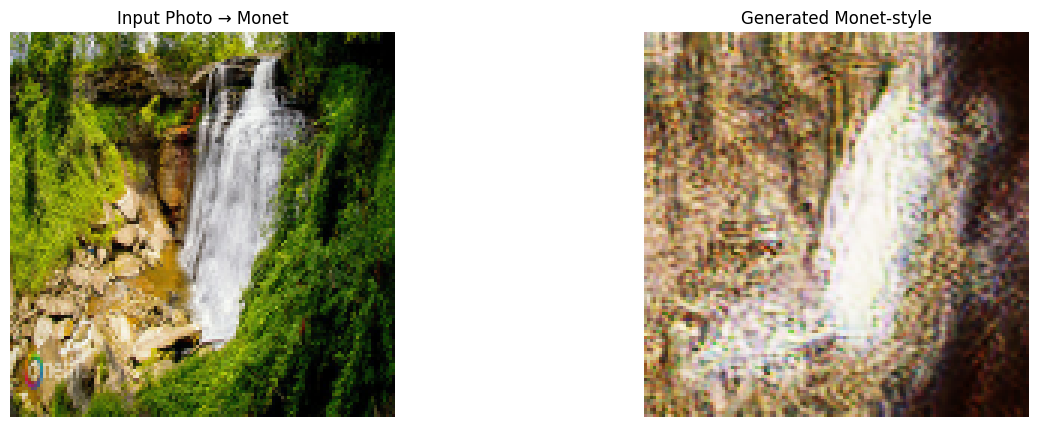

Step 600/1126 - discriminator loss: 0.2629, generator loss: 0.2831

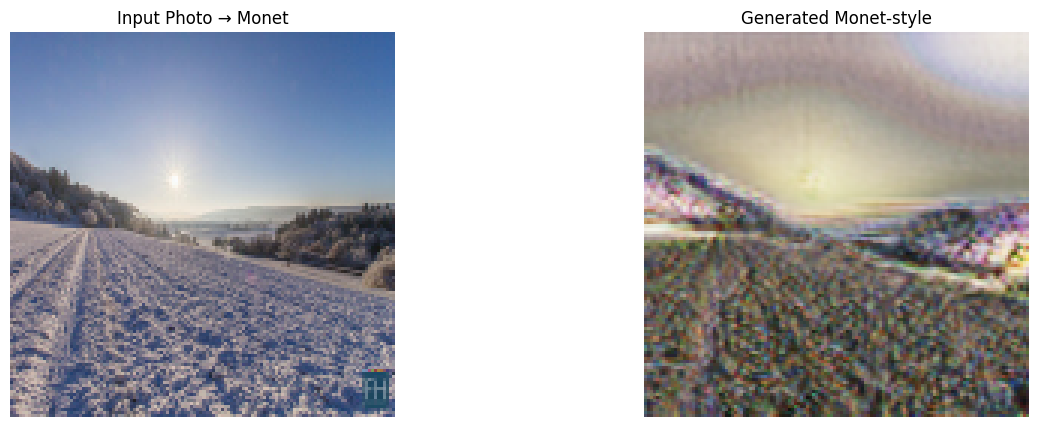

Step 700/1126 - discriminator loss: 0.2456, generator loss: 0.2685

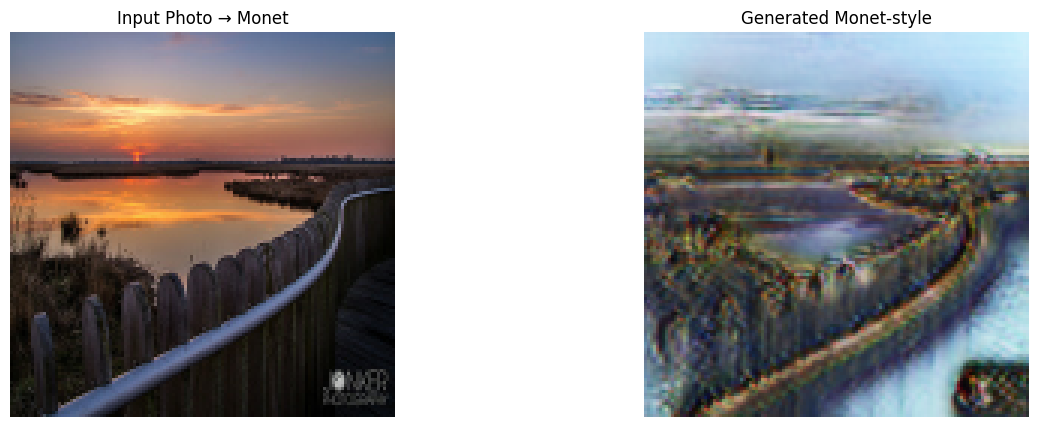

Step 800/1126 - discriminator loss: 0.2026, generator loss: 0.3033

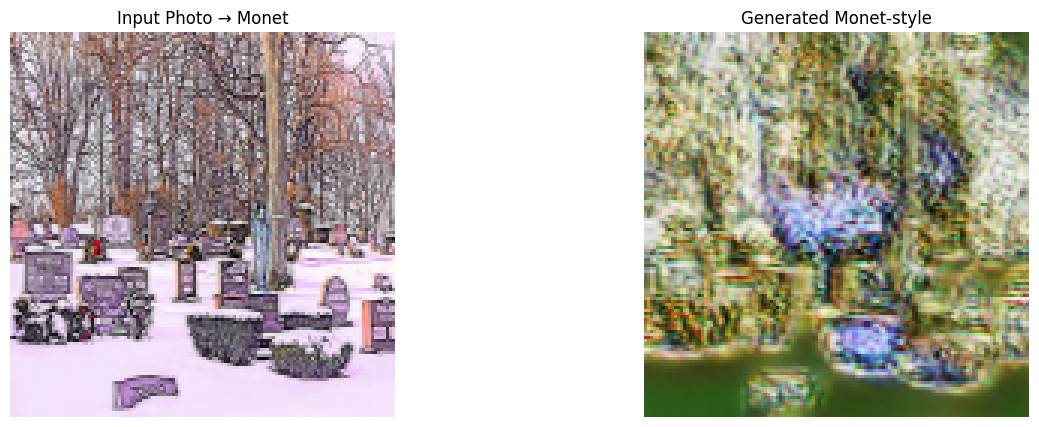

Step 900/1126 - discriminator loss: 0.2522, generator loss: 0.2592

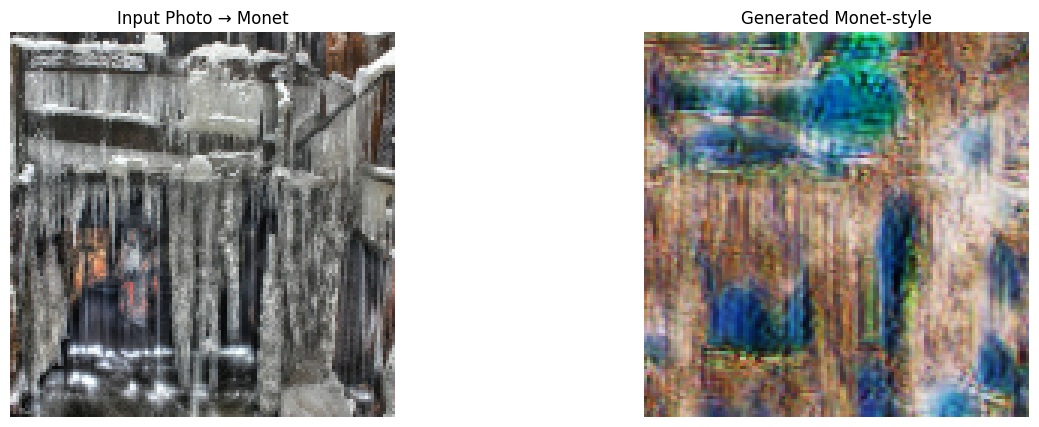

Step 1000/1126 - discriminator loss: 0.2398, generator loss: 0.2246

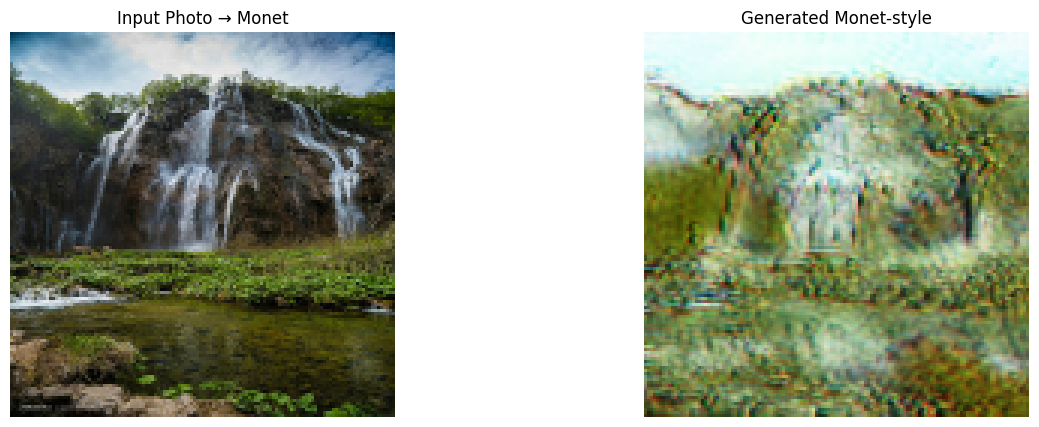

Step 1100/1126 - discriminator loss: 0.2412, generator loss: 0.1891

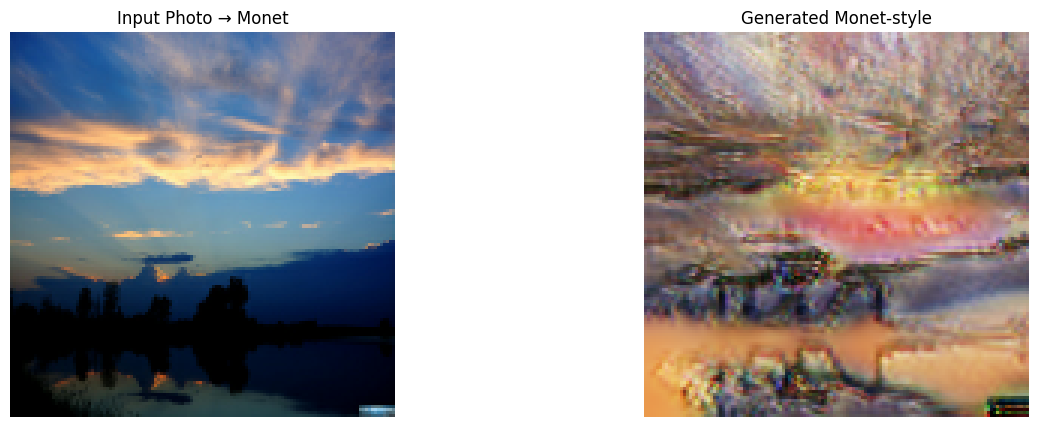

Step 1126/1126 - discriminator loss: 0.2578, generator loss: 0.2953
Epoch 2 completed in 945s - avg discriminator loss: 0.2508, avg generator loss: 0.2592


In [42]:
from keras.optimizers import Adam
import numpy as np
import time

NUM_EPOCHS = 2
EPOCH_LENGTH = DATASET_HEIGHT // 5
DISPLAY_INTERVAL = 5  # record loss every 5 steps

my_optimiser = Adam(learning_rate=0.0002, beta_1=0.5)
gen_optimiser = Adam(learning_rate=0.0002, beta_1=0.5)

my_generator = Generator((128, 128, 3))
my_discriminator = build_discriminator()

eg_image = next(my_image_ds_train)
eg_output = my_generator(eg_image)
print(eg_output.shape)

all_losses = []

for i in range(NUM_EPOCHS):
    print(f"\nEpoch {i + 1}/{NUM_EPOCHS}")
    epoch_losses = []
    start_time = time.time()

    for j in range(EPOCH_LENGTH):
        monet_image = (next(my_monet_ds_train)) 
        real_image = (next(my_image_ds_train))


        if j % 100 == 0:
            test_photo_to_monet = my_generator(real_image)
            #test_monet_to_photo = photo_generator(monet_image)
            
            plt.figure(figsize=(15, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(to_display(real_image))
            plt.title('Input Photo → Monet')
            plt.axis('off')
            
            plt.subplot(1, 2, 2)
            plt.imshow(to_display(test_photo_to_monet))
            plt.title('Generated Monet-style')
            plt.axis('off')
            plt.show()
            plt.close()

        with tf.GradientTape(persistent=True) as tape:
            real_monet = monet_image
            fake_monet = my_generator(real_image)

            real_monet_output = my_discriminator(real_monet)
            fake_monet_output = my_discriminator(fake_monet)

            loss = 0.5 * (
                my_square_loss(tf.constant(1.0), real_monet_output) +
                my_square_loss(tf.constant(0.0), fake_monet_output)
            )

            monet_generator_loss = generator_loss(fake_monet_output)

        grads = tape.gradient(loss, my_discriminator.trainable_variables)
        my_optimiser.apply_gradients(zip(grads, my_discriminator.trainable_variables))

        generator_grads =  tape.gradient(monet_generator_loss, my_generator.trainable_variables)
        gen_optimiser.apply_gradients(zip(generator_grads, my_generator.trainable_variables))

        if j % DISPLAY_INTERVAL == 0:
            disc_loss = tf.squeeze(loss).numpy()
            gen_loss = tf.squeeze(monet_generator_loss).numpy()
            epoch_losses.append((disc_loss, gen_loss))
        print(f"\rStep {j + 1}/{EPOCH_LENGTH} - discriminator loss: {epoch_losses[-1][0]:.4f}, generator loss: {epoch_losses[-1][1]:.4f}", end='')

    epoch_avg_disc_loss = np.mean([l[0] for l in epoch_losses])
    epoch_avg_gen_loss = np.mean([l[1] for l in epoch_losses])
    print(f"\nEpoch {i + 1} completed in {int(time.time() - start_time)}s - avg discriminator loss: {epoch_avg_disc_loss:.4f}, avg generator loss: {epoch_avg_gen_loss:.4f}")
    all_losses.extend(epoch_losses)
